In [1]:
import pyro
import pyro.infer
import pyro.optim
import torch
import numpy as np
import scipy.stats as stats
import torch.distributions.constraints as constraints
import matplotlib.pyplot as plt

In [2]:
# In the meantime I'll define thin wrappers around the probability distributions
class Bernoulli:
    def __init__(self, p):
        self.p = p
    
    def sample(self, size=1):
        return stats.bernoulli.rvs(p=self.p, size=size)
        
class Uniform:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def sample(self, size=1):
        return stats.uniform.rvs(loc=self.start, scale=self.end-self.start, size=size)
    
    def pdf(self, x):
        return stats.uniform.pdf(x, loc=self.start, scale=self.end-self.start)
    
    def mean(self):
        return stats.uniform.mean(loc=self.start, scale=self.end-self.start)
        
class Beta:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def pdf(self, X):
        return stats.beta.pdf(X, a=self.alpha, b=self.beta)
    
    def mean(self):
        return stats.beta.mean(a=self.alpha, b=self.beta)
    
    
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, X):
        return stats.norm.pdf(X, loc=self.mu, scale=self.sigma)
    
    def sample(self, size=1):
        return stats.norm.rvs(loc=self.mu, scale=self.sigma, size=size)
    
    def mean(self):
        return self.mu

In [3]:
plt.rcParams['figure.figsize'] = [14, 8]

# Experiment

I'll try to solve numerically with **Pyro** package the model I've analyzed analytically in the previous example

# Example - discrete case

Let's consider a simple example, where:
- Prior $\mathbb{P}(\theta) \sim U(0, 1)$
- Likelihood $\mathbb{P}(X | \theta) \sim B(\theta)$

In [4]:
def prior():
    return pyro.sample("prior", pyro.distributions.Uniform(0, 1))

In [5]:
def likelihood(theta, size):
    return pyro.sample("likelihood", pyro.distributions.Bernoulli(theta).expand_by((size,)))

In [6]:
theta = prior()

In [7]:
theta

tensor(0.9123)

In [8]:
X = likelihood(theta, 100)

In [9]:
X

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
def model(size):
    theta = prior()
    return likelihood(theta, size)

In [11]:
successes = X.sum().item()

In [12]:
successes

90.0

In [13]:
failures = (1 - X).sum().item()

In [14]:
failures

10.0

In [15]:
CX = pyro.condition(model, {'likelihood': X})

In [16]:
def guide(size):
    a = pyro.param("a", torch.tensor(1.0), constraint=constraints.positive)
    b = pyro.param("b", torch.tensor(1.0), constraint=constraints.positive)
    return pyro.sample("prior", pyro.distributions.Beta(a, b))

In [17]:
svi = pyro.infer.SVI(
    model=CX,
    guide=guide,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO()
)

a =  10.72339153289795
b =  84.82371520996094


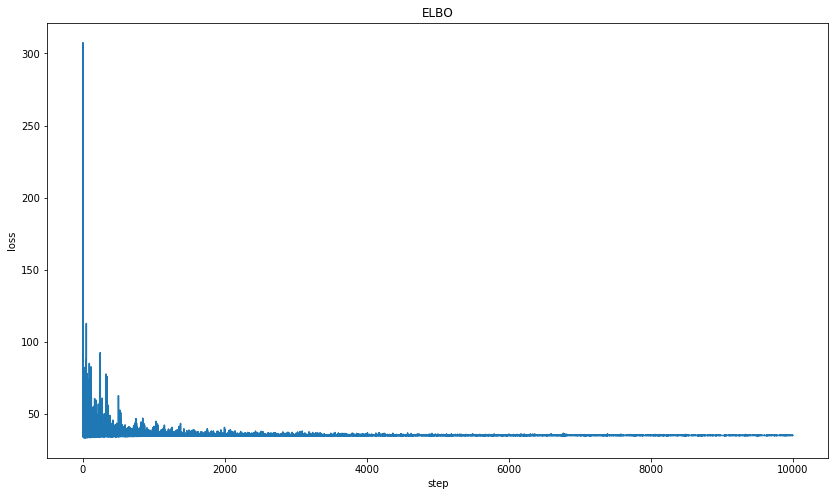

In [18]:
losses, a,b  = [], [], []
num_steps = 10_000
for t in range(num_steps):
    losses.append(svi.step(X.size(0)))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ', pyro.param("b").item())
print('b = ', pyro.param("a").item())

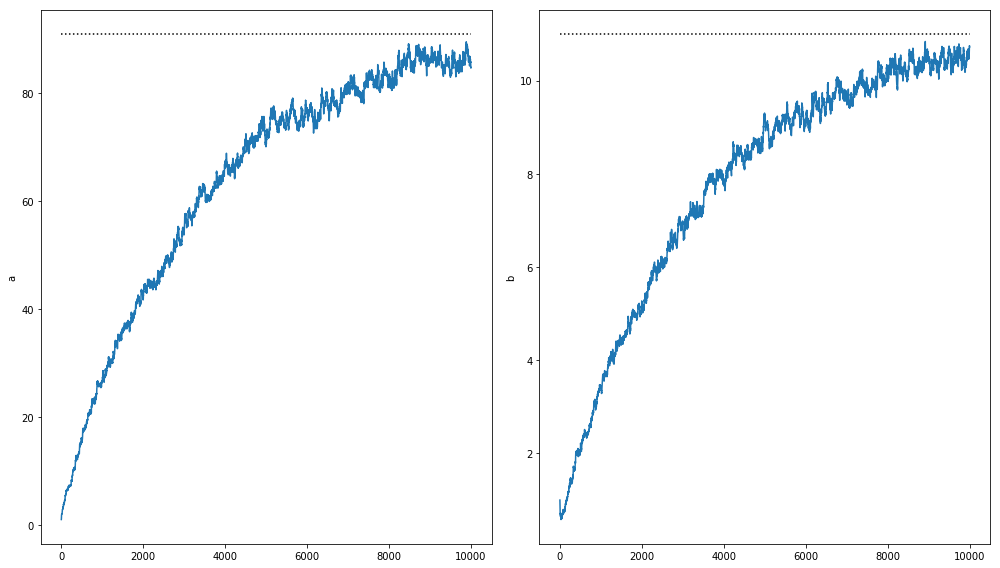

In [19]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[successes + 1, successes + 1], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[failures + 1, failures + 1], 'k:')
plt.plot(b)
plt.tight_layout()

In [20]:
A = pyro.param("a").item()
B = pyro.param("b").item()

In [21]:
Prior = Beta(1, 1)
TruePosterior = Beta(X.sum().item() + 1, (1-X).sum().item() + 1)
EstimatedPosterior = Beta(A, B)

In [22]:
MLE = (A - 1) / (A + B - 2)

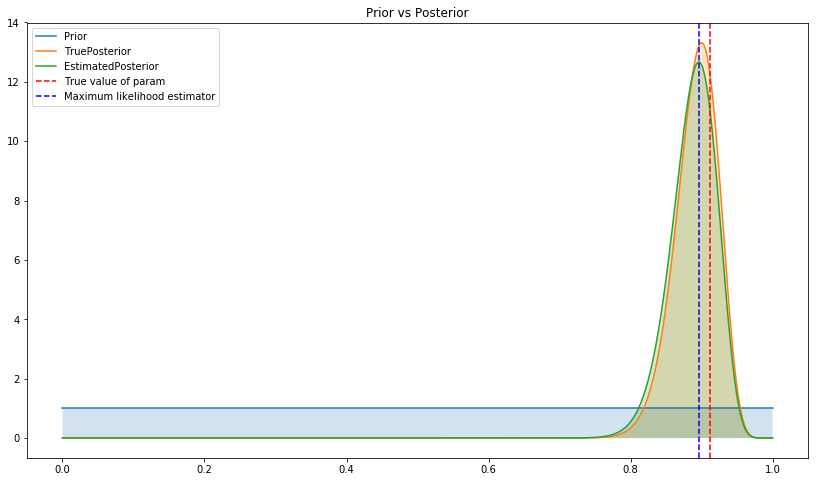

In [23]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Prior vs Posterior")
support = np.linspace(0.0, 1.0, 1000)

axs.plot(support, Prior.pdf(support), label="Prior")
axs.fill_between(support, 0, Prior.pdf(support), alpha=0.2)
axs.plot(support, TruePosterior.pdf(support), label="TruePosterior")
axs.fill_between(support, 0, TruePosterior.pdf(support), alpha=0.2)
axs.plot(support, EstimatedPosterior.pdf(support), label="EstimatedPosterior")
axs.fill_between(support, 0, EstimatedPosterior.pdf(support), alpha=0.2)
axs.axvline(theta, color='red', linestyle='--', label='True value of param')
axs.axvline(MLE, color='blue', linestyle='--', label='Maximum likelihood estimator')


axs.legend()

# Second example - continuous case

- Prior $\mathbb{P}(\theta) \sim N(0, 1)$
- Likelihood $\mathbb{P}(X | \theta) \sim N(\theta, 1)$

In [24]:
N = 100

In [25]:
Prior = Normal(0, 1)

In [26]:
hidden_theta = Prior.sample()[0]
hidden_theta

0.7940942454623553

In [27]:
Likelihood = Normal(hidden_theta, 1)

In [28]:
X = Likelihood.sample(N)

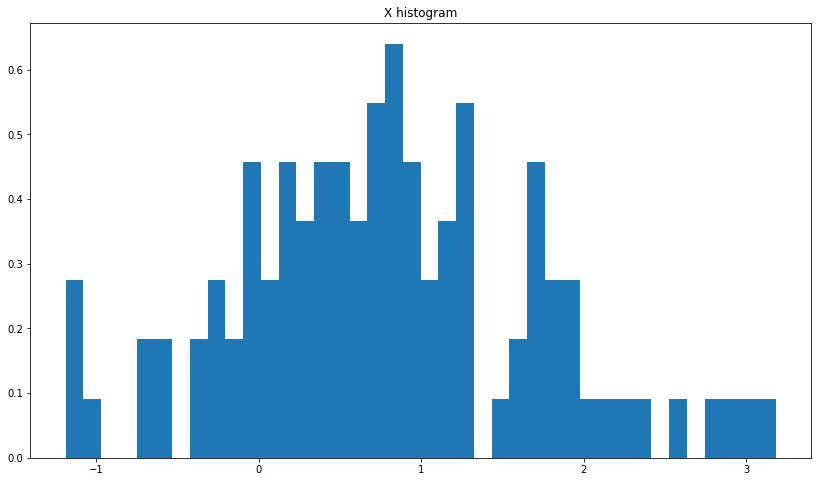

In [29]:
fig, axs = plt.subplots(1, 1)
axs.set_title("X histogram")
axs.hist(X, bins=40, density=True)
None

In [30]:
def model(size):
    theta = pyro.sample("continuous_prior", pyro.distributions.Normal(0, 1))
    
    with pyro.plate('observe_data'):
        data = pyro.sample("continuous_likelihood", pyro.distributions.Normal(theta, 1).expand_by([size]), obs=X)

    return data

In [34]:
pyro.param("c_a", torch.tensor(1.0))
pyro.param("c_b", torch.tensor(1.0), constraint=constraints.positive)

tensor(1., grad_fn=<AddBackward0>)

In [35]:
def guide(size):
    mu = pyro.param("c_a", torch.tensor(1.0))
    std = pyro.param("c_b", torch.tensor(1.0), constraint=constraints.positive)
    return pyro.sample("continuous_prior", pyro.distributions.Normal(mu, std))

In [36]:
continuous_svi = pyro.infer.SVI(
    model=model,
    guide=guide,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO()
)

mu =  1.0
std =  1.0


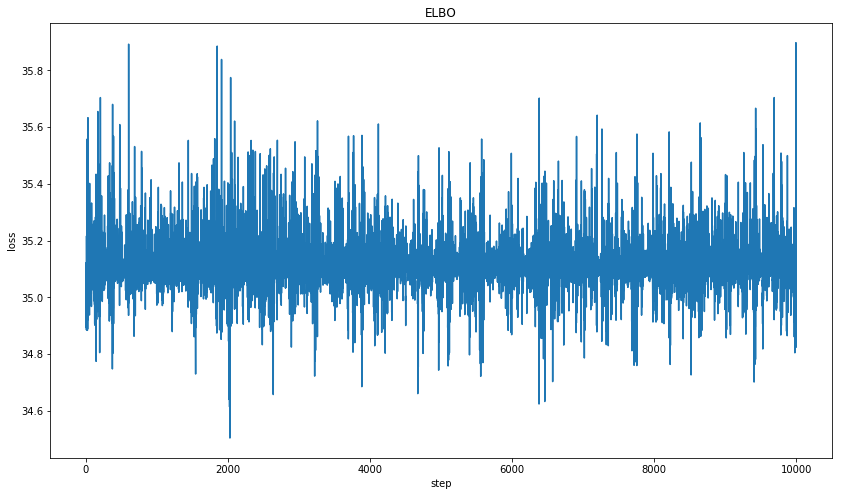

In [37]:
losses, a_history,b_history  = [], [], []
num_steps = 10_000
for t in range(num_steps):
    losses.append(svi.step(X.size))
    a_history.append(pyro.param("c_a").item())
    b_history.append(pyro.param("c_b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('mu = ', pyro.param("c_a").item())
print('std = ', pyro.param("c_b").item())

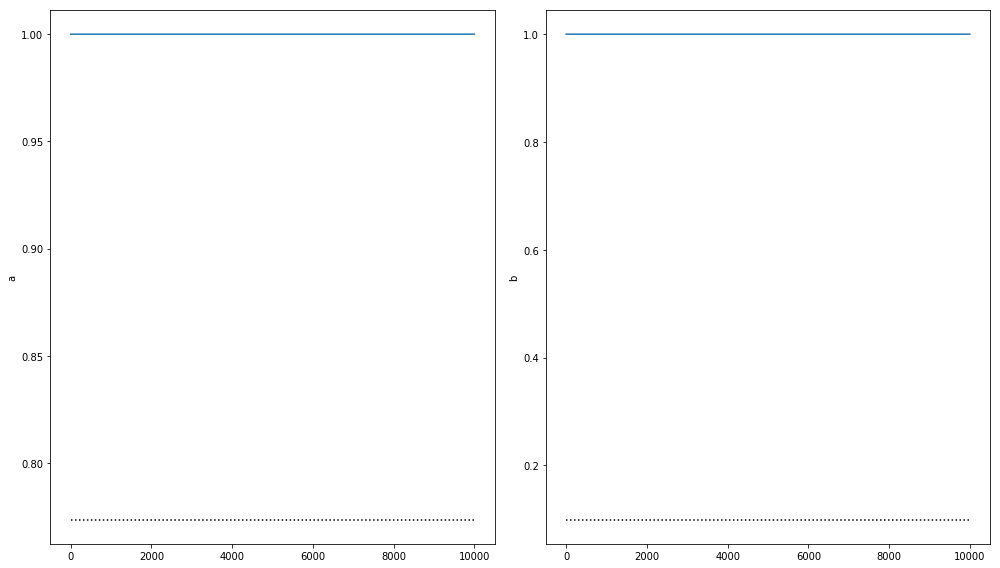

In [38]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[X.sum() / (X.size + 1), X.sum() / (X.size + 1)], 'k:')
plt.plot(a_history)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[1.0 / np.sqrt(X.size + 1), 1.0 / np.sqrt(X.size + 1)], 'k:')
plt.plot(b_history)
plt.tight_layout()

In [39]:
# Analytical posterior
Prior = Normal(0, 1)
AnalyticalPosterior = Normal(X.sum() / (X.size + 1), 1.0 / np.sqrt(X.size + 1))

In [40]:
print(hidden_theta)
mle = AnalyticalPosterior.mean()
print(AnalyticalPosterior.mean())

0.7940942454623553
0.7736120168405161


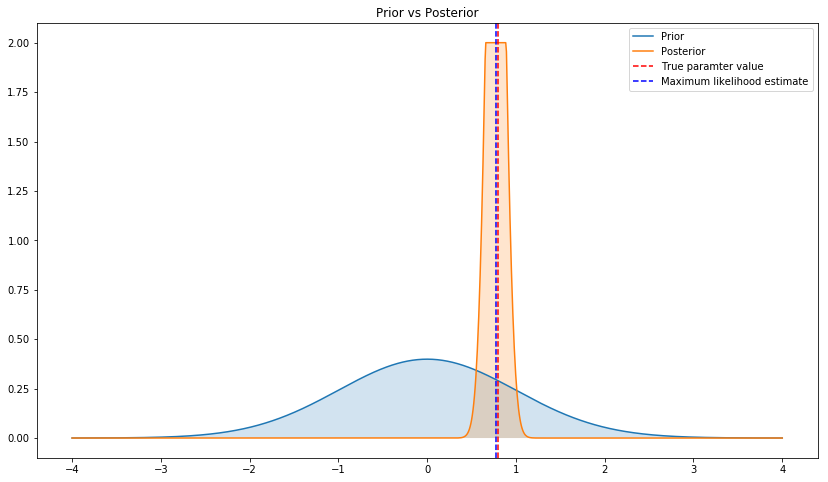

In [41]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Prior vs Posterior")
support = np.linspace(-4, 4, 10_00)

axs.plot(support, Prior.pdf(support), label="Prior")
axs.fill_between(support, 0, Prior.pdf(support), alpha=0.2)
axs.plot(support, np.minimum(AnalyticalPosterior.pdf(support), 2.0), label="Posterior")
axs.fill_between(support, 0, np.minimum(AnalyticalPosterior.pdf(support), 2.0), alpha=0.2)
axs.axvline(hidden_theta, color='red', linestyle='--', label="True paramter value")
axs.axvline(mle, color='blue', linestyle='--', label="Maximum likelihood estimate")


axs.legend()